In [1]:
import numpy as np  # provides multi-dimensional array and matrices functionality
import pandas as pd  # provides interface for interacting with tabular data
import matplotlib.pyplot as plt  # provides plotting tools
import seaborn as sns  # visualization tools
%matplotlib inline
from scipy.ndimage.filters import gaussian_filter
# %conda install folium -c conda-forge
import folium  # gis visualization
from folium import plugins
from folium.plugins import HeatMap  # heatmap visualization package
cc = pd.read_csv("/Users/lulu/Desktop/bottle.csv")  # CalCOFI bottle data

surface = cc[cc['Depthm'] == 0]  # select surface level data

aspects = surface[['Sta_ID', 'Depth_ID', 'T_degC', 'Salnty', 'O2ml_L', 'ChlorA']].fillna(0)  # tentative data layers separation, replace NaNs with 0

yymm = list(aspects["Depth_ID"])  # using Depth_ID to extract year and month, add to dataframe
year = []
month = []
for i in yymm:
    yr = int(i[:2] + i[3:5])
    mon = int(i[5:7])
    year.append(yr)
    month.append(mon)

aspects.insert(1,"Year", year, True)
aspects.insert(2, "Month", month, True)
del aspects["Depth_ID"]

aspects_15 = aspects[aspects['Year']==2015]  # selecting April of 2015
spring_15 = aspects_15[aspects_15['Month']==4]
spring_15
coords = pd.read_csv("/Users/lulu/Desktop/CalCOFIStationOrder.csv")  # CalCOFI Station Order Data
lat_lon = coords[['Line', 'Sta', 'Lat (dec)', 'Lon (dec)']]  # isolate columns

line = []  #separating line and station in bottle data to match coordinate data
station = []
sta_id = list(spring_15['Sta_ID'])
for i in sta_id:
    li = float(i[:5])
    sta = float(i[6:])
    line.append(li)
    station.append(sta)
    
spring_15.insert(0,"Line", line, True)
spring_15.insert(1, "Sta", station, True)

merged = pd.merge(spring_15, lat_lon, how='left', left_on=['Line','Sta'], right_on = ['Line','Sta']) #merge bottle and coordinate data
m_salt = folium.Map(location=[32.88719,-117.2546], tiles="Stamen Terrain", zoom_start=6)  # general mapping

salt_data = [[row['Lat (dec)'],row['Lon (dec)'],row['Salnty']] for index, row in merged.iterrows()]
salt_data = np.array(salt_data)




/Users/lulu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (47,73) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


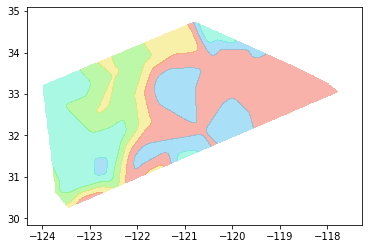

In [2]:
import numpy as np
import pandas as pd
import folium
import branca
from folium import plugins
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage
 
# Setup
temp_mean = salt_data[:,2].mean()
temp_std  = salt_data[:,2].std()
debug     = False
 
# Setup colormap
colors = ['#55c3f2',  '#55f2c8',  '#7cf255',  '#f2e255',  '#f26755']
vmin   = temp_mean - 2 * temp_std
vmax   = temp_mean + 2 * temp_std
levels = len(colors)
cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)
 
# Create a dataframe with fake data
# df = pd.DataFrame({
#     'longitude':   np.random.normal(-120,     0.15,     1000),
#     'latitude':    np.random.normal(33,     0.15,     1000),
#     'temperature': np.random.normal(temp_mean, temp_std, 1000)})
 
# The original data
x_orig = np.asarray(salt_data[:,1])
y_orig = np.asarray(salt_data[:,0])
z_orig = np.asarray(salt_data[:,2])
 
# Make a grid
x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
 
# Grid the values
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')
 
# Gaussian filter the grid to make it smoother
sigma = [5, 5]
z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')
 
# Create the contour
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors, linestyles='None', vmin=vmin, vmax=vmax)
 
# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.5)
 
# Set up the folium plot
geomap = folium.Map([salt_data[:,0].mean(), salt_data[:,1].mean()], zoom_start=6, tiles="cartodbpositron")
 
# Plot the contour plot on folium
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   1,
    }).add_to(geomap)
 
# Add the colormap to the folium map
cm.caption = 'Temperature'
geomap.add_child(cm)
 
# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)
geomap